# Kaggle Competition: House Prices - Advanced Regression Techniques

## Introduction

The code in this notebook was created to participate in the `House Prices - Advanced Regression Techniques` competition on `kaggle.com`. To complete the task, current knowledge, the book `Introduction to Machine Leaning with Python` by Sandra Guido and Andreas C. Müller as well as the input from the huge amount of submitted code available on `kaggle.com` were used. Hence, I would like to thank everyone who submitted their project. Especially the following projects were very helpful:

* `https://www.kaggle.com/apapiu/regularized-linear-models`
* `https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition`

## Start of the project

### Import modules:

Modules for data manipulation and calculations:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p

Modules for visualizations:

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

Modules for machine learning algorithms/models, model validation and data preprocessing:

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Import the data:

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [5]:
print(len(train_data.columns))
print(len(test_data.columns))

81
80


Test dataset has a lower number of features compared to the training dataset. As expected, it is the dependent variable:

In [6]:
for train_col in train_data.columns:
    if train_col not in test_data.columns:
        print(train_col)

SalePrice


## Exploratory Data Analysis:

In the following, the dataset at hand will be explored. A brief overview/ description of the dataset's features can be found on Kaggle (`https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data`). In addition, the dataset comes with a text file encompassing information on all features.

### Dependent variable: SalePrice

First things first: plot the dependent variable's distribution.

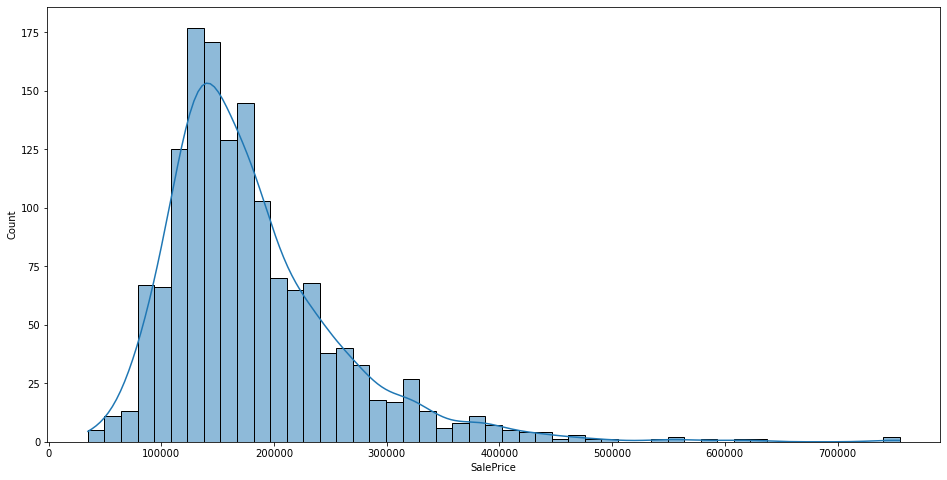

In [7]:
fig, ax = plt.subplots(figsize = (16, 8))
sns.histplot(data=train_data, x = "SalePrice", kde = True)
plt.show()

The distribution seems to be right-skewed. Next, we examine the skewness and kurtosis to confirm this finding.

**Skewness**: measure of the asymmetry of the probability distribution of a random variable about its mean. In other words, skewness tells you the amount and direction of skew (departure from horizontal symmetry). If skewness is 0, the distribution is perfectly symmetrical (normal distribution; rarely seen in real world data). In general, it is assumed that a distribution is approximately symmetric if skewness is between -0.5 and 0.5.

**Kurtosis**: tells you the height and sharpness of the central peak, relative to that of a standard bell curve. The kurtosis for a normal distribution is 3.

In [8]:
print(f"Skewness: {round(train_data['SalePrice'].skew(), 1)}")
print(f"Kurtosis: {round(train_data['SalePrice'].kurt(), 1)}")

Skewness: 1.9
Kurtosis: 6.5


As presumed, the skewness (appr. 1.9) as well as the kurtosis of (appr. 6.5) indicate that the dependent variable's distribution is not normal. This is a problem, because most machine learning models do not perform well with non-normally distributed data. Therefore, a log-tranformation is applied to make the data (more) normal:

In [9]:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

To inspect the results of the log-transformation, both a normal distribution as well as the real distribution are plotted. In order to do that, normality is assumed to fit a normal distribution to our data. Eventually, the parameters $\mu$ and $\sigma$ are obtained. These parameters are used to plot the normal curve.

In [10]:
(mu, sigma) = stats.norm.fit(train_data['SalePrice'])

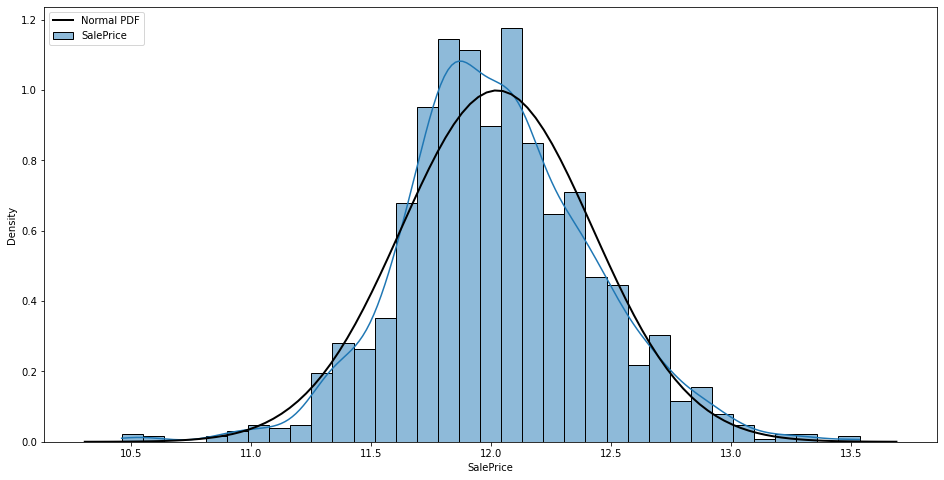

In [11]:
fig = plt.figure(figsize = (16, 8))

# Histogram of data:
ax = sns.histplot(data = train_data, x = 'SalePrice', kde = True, stat = "density", label = "SalePrice")

# Normal distribution:
x0, x1 = ax.get_xlim()
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf, mu, sigma)
ax.plot(x_pdf, y_pdf, 'black', lw = 2, label = 'Normal PDF')

plt.legend(loc = "upper left")
plt.show()

As indicated by the plot, the empirical distribution resembles a normal distribution. To provide further evidence, both the empirical and normal distributions are compared with the aid of a probability plot:

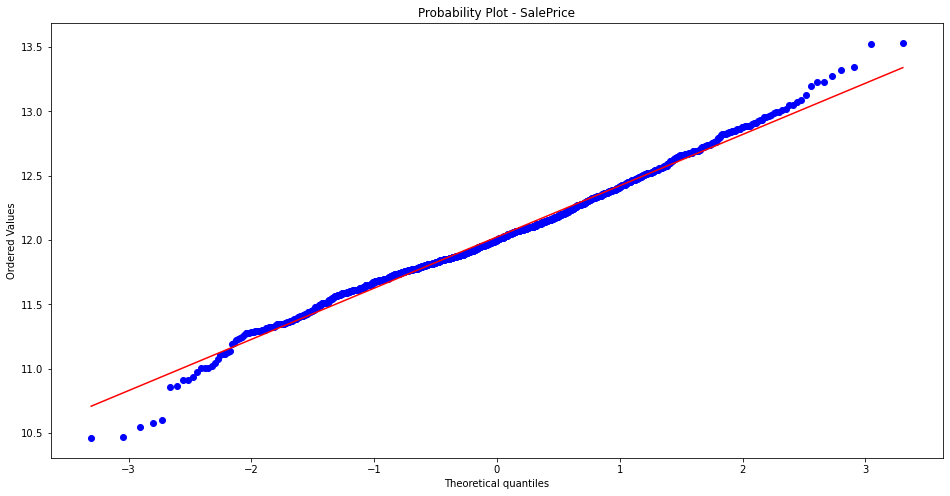

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
stats.probplot(train_data["SalePrice"], plot = ax)
plt.title("Probability Plot - SalePrice")
plt.show()

As already stated: the empirical distribution looks almost after the log-transformation.

### Independent variables:

Determine the data types of all variables:

In [13]:
continuous_features = list(train_data.select_dtypes(exclude = ["object"]))
continuous_features.remove("SalePrice")
categorical_features = list(train_data.select_dtypes(include = ["object"]))

In [14]:
print(len(continuous_features) + len(categorical_features))

80


**Continuous features**:

In [15]:
# print(continuous_features)

Some of the continuous features do look like categorical features. Hence, these features are converted as shown in the following:

In [16]:
train_data = train_data.replace({"MSSubClass": {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45", 
                                                 50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75", 
                                                 80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120", 
                                                 150: "SC150", 160: "SC160", 180: "SC180", 190: "SC190"},
                                 "MoSold": {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                                             7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}})

In [17]:
train_data["YrSold"] = train_data["YrSold"].astype(str)

In [18]:
test_data = test_data.replace({"MSSubClass": {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45", 
                                                 50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75", 
                                                 80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120", 
                                                 150: "SC150", 160: "SC160", 180: "SC180", 190: "SC190"},
                                 "MoSold": {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                                             7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11 : "Nov", 12: "Dec"}})

In [19]:
test_data["YrSold"] = test_data["YrSold"].astype(str)

**Categorical data**:

In [20]:
categorical_features = list(train_data.select_dtypes(include = ["object"]))

In [21]:
# print(categorical_features)

Some of the categorical features can be encoded as dummy variables. Additionally, for some features orders/rankings are observable (see data description). This order/ranking can be used for dummy encoding:

In [22]:
train_data = train_data.replace({"Street": {"Grvl": 1, "Pave": 2},
                       "Alley": {"Grvl": 1, "Pave": 2},
                       "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
                       "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
                      "LandSlope": {"Sev": 1, "Mod" : 2, "Gtl" : 3},
                      "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "BsmtQual": {"No": 0, "Po": 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "BsmtCond": {"No": 0, "Po": 1, "Fa" : 2, "TA" : 3, "Gd": 4, "Ex": 5},
                      "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
                      "BsmtFinType1": {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
                      "BsmtFinType2": {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
                      "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "Central Air": {"N": 0, "Y": 1}, 
                      "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                      "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                      "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}})

In [23]:
test_data = test_data.replace({"Street": {"Grvl": 1, "Pave": 2},
                       "Alley": {"Grvl": 1, "Pave": 2},
                       "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
                       "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
                      "LandSlope": {"Sev": 1, "Mod" : 2, "Gtl" : 3},
                      "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "BsmtQual": {"No": 0, "Po": 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "BsmtCond": {"No": 0, "Po": 1, "Fa" : 2, "TA" : 3, "Gd": 4, "Ex": 5},
                      "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
                      "BsmtFinType1": {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
                      "BsmtFinType2": {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
                      "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                      "Central Air": {"N": 0, "Y": 1}, 
                      "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                      "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                      "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}})

### Handle missings values:

In [24]:
missings_total = train_data.isna().sum().sort_values(ascending = False)
missings_pct = missings_total / len(train_data)
missing_data = pd.concat([missings_total, missings_pct], axis = 1, keys = ['Total', 'Percent'])

In [25]:
# missing_data[missing_data["Total"] > 0]

Check the data description text file (mentioned above) to find appropriate values to replace the missing values:

In [26]:
train_data["PoolQC"] = train_data["PoolQC"].fillna("No pool")
train_data["MiscFeature"] = train_data["MiscFeature"].fillna("No feature")
train_data["Alley"] = train_data["Alley"].fillna("No alley access")
train_data["Fence"] = train_data["Fence"].fillna("No fence")
train_data["FireplaceQu"] = train_data["FireplaceQu"].fillna("No fireplace")
train_data["LotFrontage"] = train_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
train_data["GarageYrBlt"] = train_data["GarageYrBlt"].fillna(0)
train_data["GarageCond"] = train_data["GarageCond"].fillna(0)
train_data["GarageType"] = train_data["GarageType"].fillna("No garage")
train_data["GarageFinish"] = train_data["GarageFinish"].fillna("No garage")
train_data["GarageQual"] = train_data["GarageQual"].fillna(0)
train_data["BsmtExposure"] = train_data["BsmtExposure"].fillna(0)
train_data["BsmtFinType2"] = train_data["BsmtFinType2"].fillna(0)
train_data["BsmtQual"] = train_data["BsmtQual"].fillna(0)
train_data["BsmtCond"] = train_data["BsmtCond"].fillna(0)
train_data["BsmtFinType1"] = train_data["BsmtFinType1"].fillna(0)
train_data["MasVnrType"] = train_data["MasVnrType"].fillna("No type")
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(0)
train_data["Electrical"] = train_data["Electrical"].fillna(train_data["Electrical"].mode()[0])

Final check for missings:

In [27]:
print(sum(train_data.isna().sum()))

0


Repeat the whole process for the test data:

In [28]:
missings_total = test_data.isna().sum().sort_values(ascending=False)
missings_pct = missings_total / len(test_data)
missing_data = pd.concat([missings_total, missings_pct], axis=1, keys=['Total', 'Percent'])

In [29]:
# missing_data[missing_data["Total"] > 0]

In [30]:
test_data["PoolQC"] = test_data["PoolQC"].fillna("No pool")
test_data["MiscFeature"] = test_data["MiscFeature"].fillna("No feature")
test_data["Alley"] = test_data["Alley"].fillna("No alley access")
test_data["Fence"] = test_data["Fence"].fillna("No fence")
test_data["FireplaceQu"] = test_data["FireplaceQu"].fillna("No fireplace")
test_data["LotFrontage"] = test_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test_data["GarageYrBlt"] = test_data["GarageYrBlt"].fillna(0)
test_data["GarageCond"] = test_data["GarageCond"].fillna(0)
test_data["GarageType"] = test_data["GarageType"].fillna("No garage")
test_data["GarageFinish"] = test_data["GarageFinish"].fillna("No garage")
test_data["GarageQual"] = test_data["GarageQual"].fillna(0)
test_data["GarageArea"] = test_data["GarageArea"].fillna(0)
test_data["GarageCars"] = test_data["GarageCars"].fillna(0)
test_data["BsmtExposure"] = test_data["BsmtExposure"].fillna(0)
test_data["BsmtFinType2"] = test_data["BsmtFinType2"].fillna(0)
test_data["BsmtQual"] = test_data["BsmtQual"].fillna(0)
test_data["BsmtCond"] = test_data["BsmtCond"].fillna(0)
test_data["BsmtFinType1"] = test_data["BsmtFinType1"].fillna(0)
test_data["MasVnrType"] = test_data["MasVnrType"].fillna("No type")
test_data["MasVnrArea"] = test_data["MasVnrArea"].fillna(0)
test_data["Electrical"] = test_data["Electrical"].fillna(test_data["Electrical"].mode()[0])
test_data["MSZoning"] = test_data["MSZoning"].fillna(test_data["MSZoning"].mode()[0])
test_data["BsmtHalfBath"] = test_data["BsmtHalfBath"].fillna(0)
test_data["BsmtFullBath"] = test_data["BsmtFullBath"].fillna(0)
test_data["Utilities"] = test_data["Utilities"].fillna(test_data["Utilities"].mode()[0])
test_data["Functional"] = test_data["Functional"].fillna(test_data["Functional"].mode()[0])
test_data["SaleType"] = test_data["SaleType"].fillna(test_data["SaleType"].mode()[0])
test_data["TotalBsmtSF"] = test_data["TotalBsmtSF"].fillna(0)
test_data["BsmtUnfSF"] = test_data["BsmtUnfSF"].fillna(0)
test_data["BsmtFinSF2"] = test_data["BsmtFinSF2"].fillna(0)
test_data["BsmtFinSF1"] = test_data["BsmtFinSF1"].fillna(0)
test_data["KitchenQual"] = test_data["KitchenQual"].fillna(test_data["KitchenQual"].mode()[0])
test_data['Exterior1st'] = test_data['Exterior1st'].fillna(test_data['Exterior1st'].mode()[0])
test_data['Exterior2nd'] = test_data['Exterior2nd'].fillna(test_data['Exterior2nd'].mode()[0])

Final check for missings:

In [31]:
print(sum(test_data.isna().sum()))

0


### Correlations:

In the following, relationships between the dependent variable and a selection of features is examined. To do so, correlation coefficients are computed.

In [32]:
corr_df = pd.DataFrame(train_data.corr()["SalePrice"].sort_values(ascending = False))

In [33]:
# corr_df

As there are a lot of features, I do concentrate on the variables with the highest correlation values:

In [34]:
highest_corr = corr_df.iloc[1:11, :]

In [35]:
highest_corr

,SalePrice
OverallQual,0.817185
GrLivArea,0.700927
GarageCars,0.680625
ExterQual,0.678840
KitchenQual,0.667893
GarageArea,0.650888
BsmtQual,0.615804
TotalBsmtSF,0.612134
1stFlrSF,0.596981
FullBath,0.594771


Visualizing the relationships:

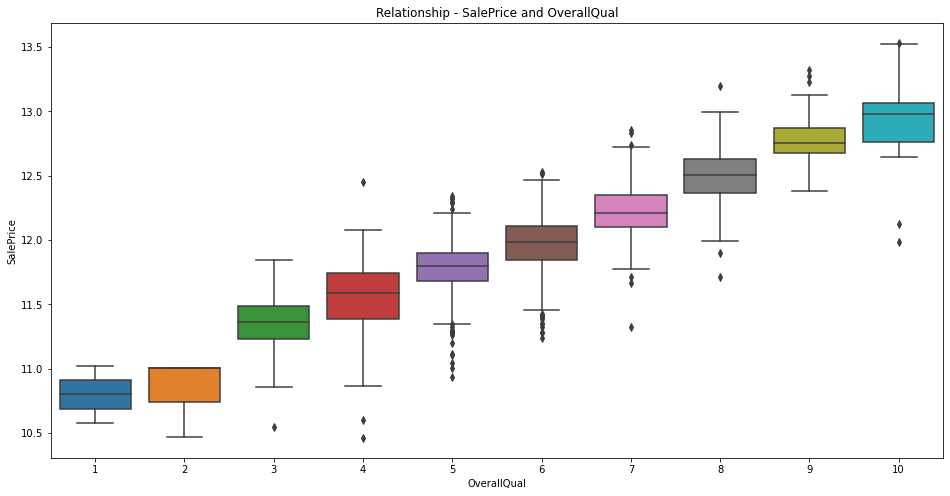

In [36]:
plt.figure(figsize=(16,8))
sns.boxplot(data=train_data, y="SalePrice", x=highest_corr.index[0])
plt.title(f"Relationship - SalePrice and {highest_corr.index[0]}")
plt.show()

The positive relationship makes sense. A higher overall quality leads to a higher sale price. 

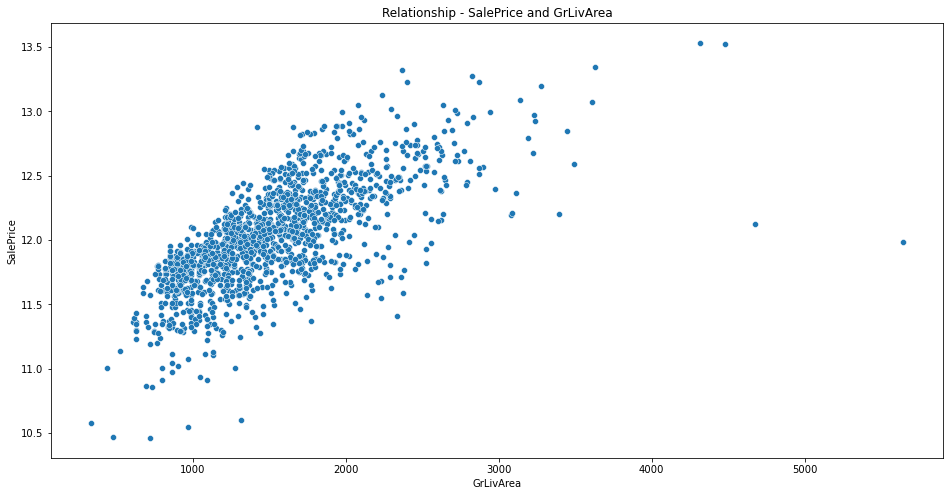

In [37]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=train_data, y="SalePrice", x=highest_corr.index[1])
plt.title(f"Relationship - SalePrice and {highest_corr.index[1]}")
plt.show()

Reasonable positive relation between ground living area and sale price. 

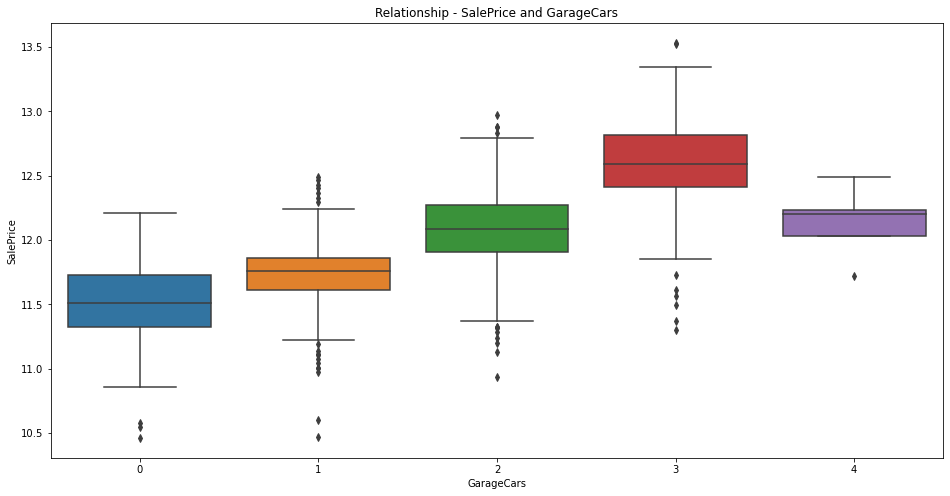

In [38]:
plt.figure(figsize=(16,8))
sns.boxplot(data=train_data, y="SalePrice", x=highest_corr.index[2])
plt.title(f"Relationship - SalePrice and {highest_corr.index[2]}")
plt.show()

Mainly positive relation between the sale price and the garages' space for cars seems reasonable.

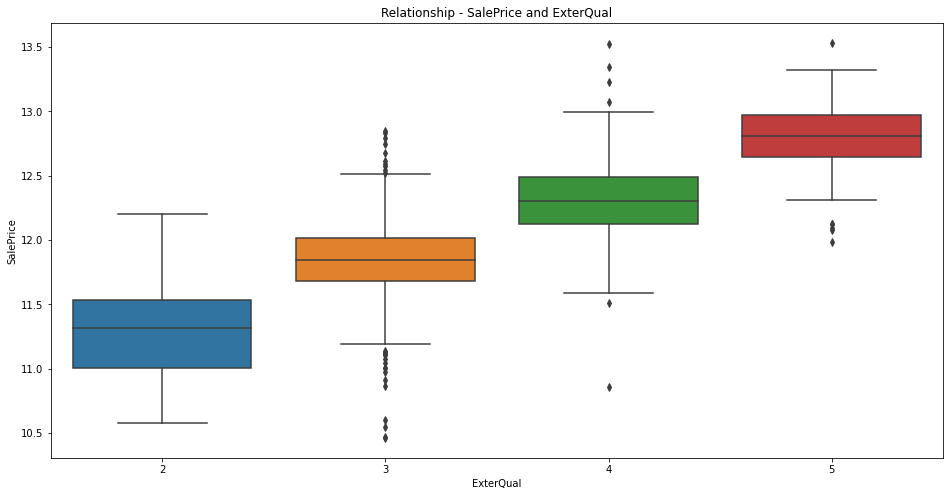

In [39]:
plt.figure(figsize=(16,8))
sns.boxplot(data=train_data, y="SalePrice", x=highest_corr.index[3])
plt.title(f"Relationship - SalePrice and {highest_corr.index[3]}")
plt.show()

Higher sale prices due to higher exterior quality seems reasonable.

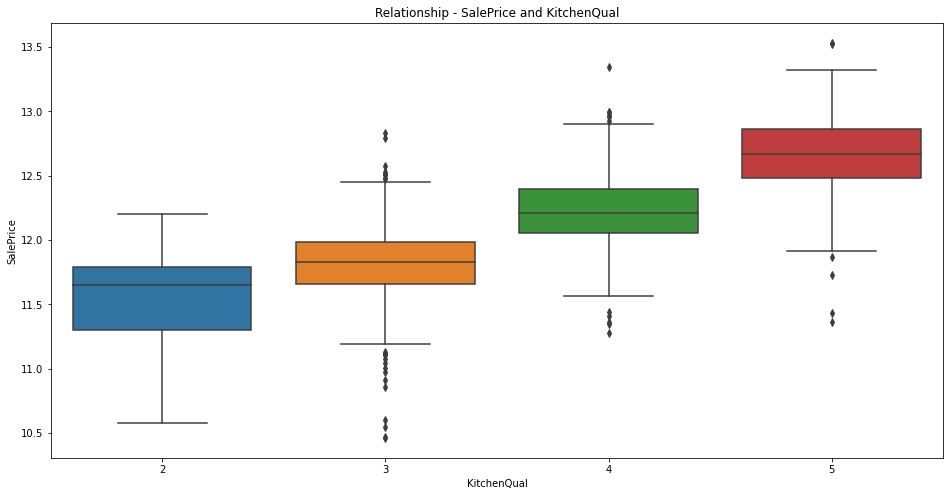

In [40]:
plt.figure(figsize=(16,8))
sns.boxplot(data=train_data, y="SalePrice", x=highest_corr.index[4])
plt.title(f"Relationship - SalePrice and {highest_corr.index[4]}")
plt.show()

Mainly positive relation between the sale price and the kitchen quality seems reasonable.

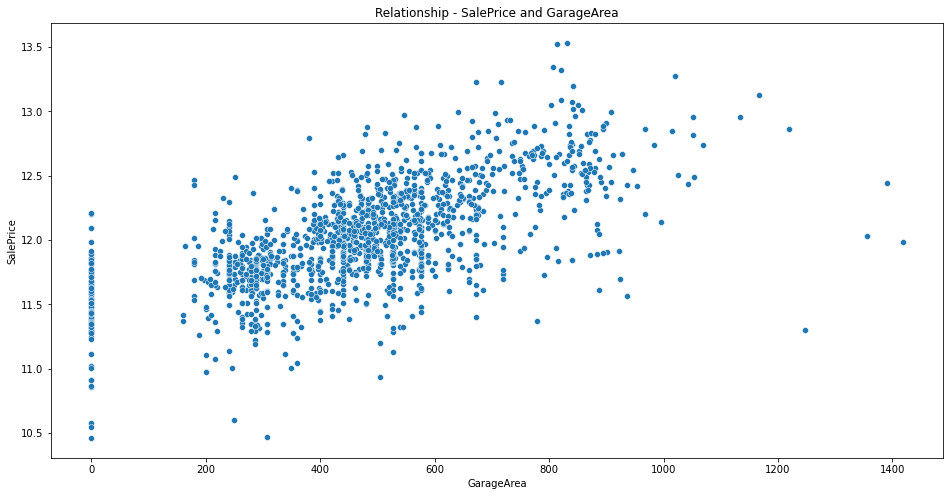

In [41]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=train_data, y="SalePrice", x=highest_corr.index[5])
plt.title(f"Relationship - SalePrice and {highest_corr.index[5]}")
plt.show()

Positive relation between the sale price and the garage area seems reasonable.

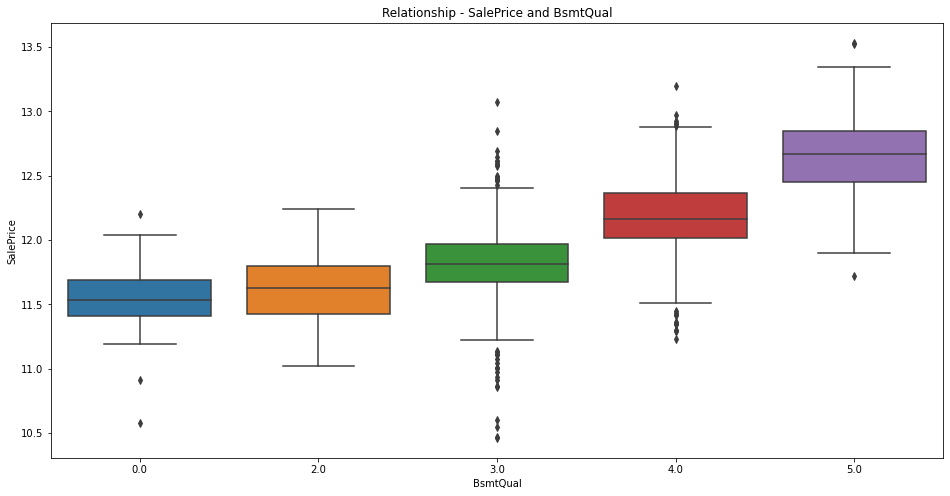

In [42]:
plt.figure(figsize=(16,8))
sns.boxplot(data=train_data, y="SalePrice", x=highest_corr.index[6])
plt.title(f"Relationship - SalePrice and {highest_corr.index[6]}")
plt.show()

Positive relation between the sale price and the basement quality does make sense.

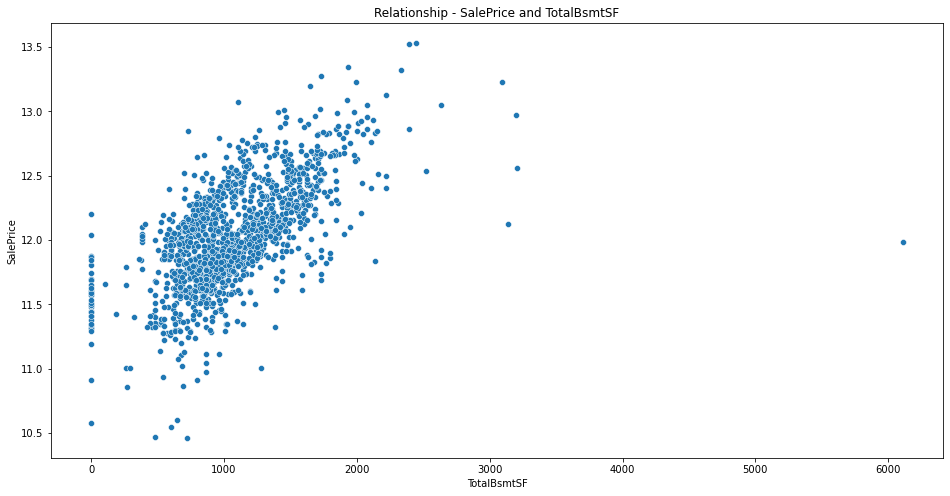

In [43]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=train_data, y="SalePrice", x=highest_corr.index[7])
plt.title(f"Relationship - SalePrice and {highest_corr.index[7]}")
plt.show()

A positive relationship between the basement's square feet and the sale price makes sense.

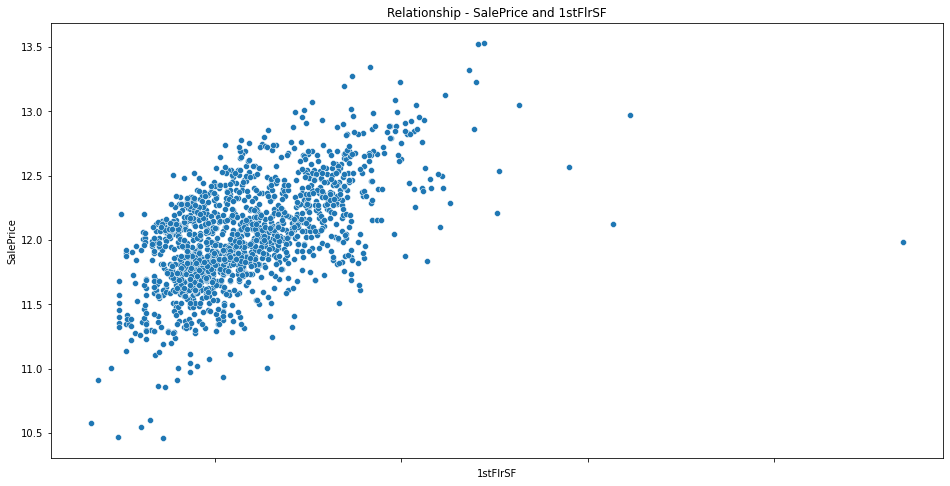

In [44]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=train_data, y="SalePrice", x=highest_corr.index[8], ax=ax)
ax.set(xticklabels=[])
ax.set_title(f"Relationship - SalePrice and {highest_corr.index[8]}")
plt.show()

A positive relationship between the first floor square feet and the sale price makes sense.

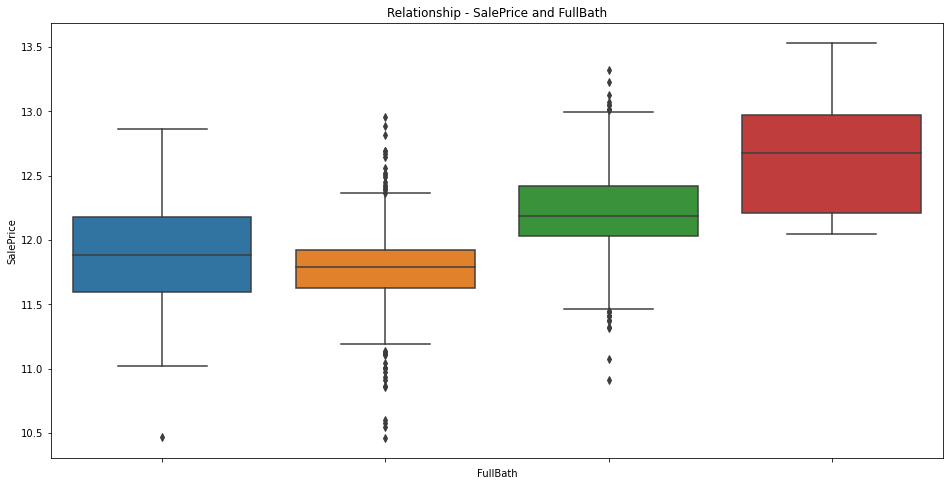

In [45]:
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=train_data, y="SalePrice", x=highest_corr.index[9], ax=ax)
ax.set(xticklabels=[])
ax.set_title(f"Relationship - SalePrice and {highest_corr.index[9]}")
plt.show()

Reasonable positive relation between sale prices and full baths available.

### Check for skewness of continuous features:

As already done for the dependent variable, the continuous features will be examimed with respect to their skewness. In order to that, the training and test datasets are temporarily combined:

In [46]:
complete_data = pd.concat((train_data.loc[:, 'MSSubClass':'SaleCondition'], test_data.loc[:, 'MSSubClass':'SaleCondition']))

In [47]:
continuous_features = list(complete_data.select_dtypes(exclude = ["object"]))

In [48]:
skewed_features = complete_data[continuous_features].apply(lambda x: stats.skew(x)).sort_values(ascending = False)

The threshold for (large) skewness is set to the absolute value of 0.5: 

In [49]:
high_skew = skewed_features[(skewed_features > 0.5) | (skewed_features < -0.5)]

In [50]:
print(f"Number of numerical features with skewness > 0.5 and < -0.5: {high_skew.shape[0]}")

Number of numerical features with skewness > 0.5 and < -0.5: 42


In [51]:
high_skewed_features = pd.DataFrame({'Skew': high_skew})

Plot boxplot to show the highly skewed variables:

In [52]:
# fig, ax = plt.subplots(figsize=(16, 32))
# sns.boxplot(data=all_data[high_skewed_features.index], orient="h", ax=ax)
# ax.set_xscale("log")
# plt.show()

Next, the scipy function `boxcox1p`, which computes the Box-Cox transformation, is used to normalize the features (see `https://onlinestatbook.com/2/transformations/box-cox.html` for more information). The transformation is controlled by the power parameter $\lambda$. For $\lambda$ equal to 0, the simple log-transformation as achieved by the function `np.log1p` is applied. To select an appropriate $\lambda$ value, several transformation with $\lambda$ values between 0 and 1 are tested and compared with respect to the overall skewness.

In [53]:
boxcox_lambdas = np.arange(0, 1, 0.05)

In [54]:
skew_dict = {round(key, 2): 0 for key in boxcox_lambdas}

In [55]:
for lam in boxcox_lambdas:
    df_copy = complete_data.copy()
    for feature in high_skewed_features.index:
        df_copy[feature] = boxcox1p(df_copy[feature], round(lam, 2))
    skew_dict[round(lam, 2)] = df_copy[continuous_features].skew().abs().sum()
    del df_copy

In [56]:
skew_series = pd.Series(skew_dict.values(), skew_dict.keys())

Get $\lambda$ that leads to lowest overall skewness:

In [57]:
skew_series[skew_series == skew_series.min()]

0.15    176.286181
dtype: float64

Transform continuous features with the determined $\lambda$:

In [58]:
lam = skew_series[skew_series == skew_series.min()].index.values[0]

In [59]:
for feature in high_skewed_features.index:
    complete_data[feature] = boxcox1p(complete_data[feature], lam)

## Prepare data for machine learning models:

Dummy encoding:

In [60]:
complete_data = pd.get_dummies(complete_data)

In [61]:
complete_data.shape

(2919, 270)

Split datasets into training and test datasets again:

In [62]:
X_train = complete_data.iloc[:train_data.shape[0], :]

In [63]:
X_test = complete_data.iloc[train_data.shape[0]:, :]

In [64]:
y = train_data["SalePrice"]

## Modelling:

Before starting with the models, the validation strategey is selected: a K-Fold Cross Validation with 5 subsets.

In [65]:
cross_val_folds = KFold(n_splits = 5, random_state = 69, shuffle = True)

The metric used for evaluation is the Root Mean Square Error (RMSE):

In [66]:
def root_mean_square_error_cv(model, X = X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, cv = cross_val_folds, scoring = "neg_mean_squared_error"))
    return(rmse)

In [67]:
def root_mean_square_error_pred(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Finally, an empty dictionary is defined to collect the models' scores which are eventually used for comparisons:

In [68]:
model_scores = {}

### (Unrestricted) Linear Regression:

The first model examined is an unrestricted linear regression:

In [69]:
lin_reg = LinearRegression()

First: cross-validate the model to obtain a RMSE.

In [70]:
print(root_mean_square_error_cv(lin_reg).mean())

0.16392312068432577


The root mean square error is not as high as expected. Next, a linear model is fitted to the training data. To see how much of the training datasets' variation can be explained by the model, the $R^2$ is examined:

In [71]:
fitted_lin_reg = lin_reg.fit(X_train, y)

In [72]:
print(round(fitted_lin_reg.score(X_train, y), 2) * 100)

94.0


The $R^2$ is quite high. However, that was expected because of the large number of features used to explain the variation in the dataset. Due to the large number of features, the problem of overfitting might arise. Before adressing that particular problem (by applying restricted regression models), the linear model's predictions will be examined: 

In [73]:
lin_reg_pred = fitted_lin_reg.predict(X_train)

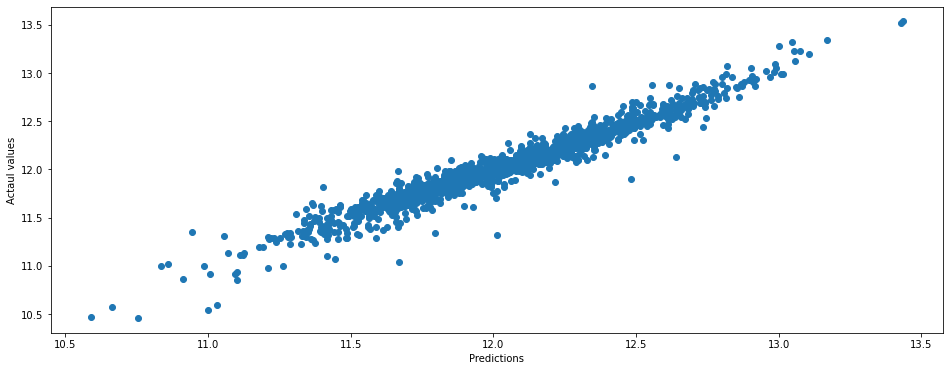

In [74]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(lin_reg_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [75]:
fitted_lin_reg_rmse = root_mean_square_error_pred(y, lin_reg_pred)
print(fitted_lin_reg_rmse)

0.09532348214969064


Surprisingly, the unrestricted linear model yields highly accurate predictions as indicated by the scatterplot as well as the low RMSE.

In [76]:
model_scores["LinearReg"] = fitted_lin_reg_rmse

### Ridge Regression

* The Ridge Regression is a restricted regression model, in which the linear regression cost function is altered by adding a penalty term equivalent to the squares of the coefficients.
* The penalty term regularizes the coefficients such that the optimization function is penalized if the coefficients approach large values. Hence, Ridge Regression shrinks the coefficients and thereby helps to reduce the dangers of overfitting, model complexity and multi-collinearity. However, coefficients are only shrinked close to zero (L2 regularization), but never zero (see LASSO regression)!
* The shrinkage depends on the magnitude of the penalty term. In `scikit-learn` the penalty term can be tuned via the paramter `alpha`.

Since the $\alpha$ value that leads to the best results is unknown, we will cross validate several models with different $\alpha$ values and compute the RMSE for each model:

In [77]:
alphas_ridge = np.arange(0.1, 20, 0.1)

In [78]:
ridge_rmse = pd.Series([root_mean_square_error_cv(Ridge(alpha = alpha, random_state = 69,
                                                        max_iter = 100000)).mean() for alpha in alphas_ridge],
                        index = alphas_ridge)

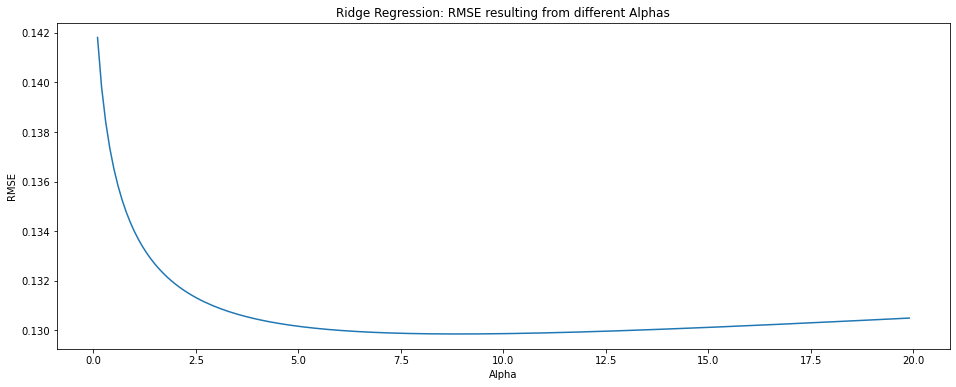

In [79]:
plt.figure(figsize=(16, 6))
ridge_rmse.plot(title = "Ridge Regression: RMSE resulting from different Alphas")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [80]:
ridge_alpha = ridge_rmse[ridge_rmse == ridge_rmse.min()].index.values[0]

Following, a Ridge Regression model with the $\alpha$ leading to the lowest RMSE is fitted to the training data:

In [81]:
fitted_ridge_reg = Ridge(alpha = ridge_alpha, random_state = 69, max_iter = 100000).fit(X_train, y)

In [82]:
round(fitted_ridge_reg.score(X_train, y), 2) * 100

93.0

As expected, the Ridge regression's performance on the training data measured by $R^2$ is lower compared to that of the unrestricted linear regression. Moreover, the lower $R^2$ indicates that overfitting is less of a problem for the Ridge Regression model. In the following, predictions are examined:

In [83]:
ridge_reg_pred = fitted_ridge_reg.predict(X_train)

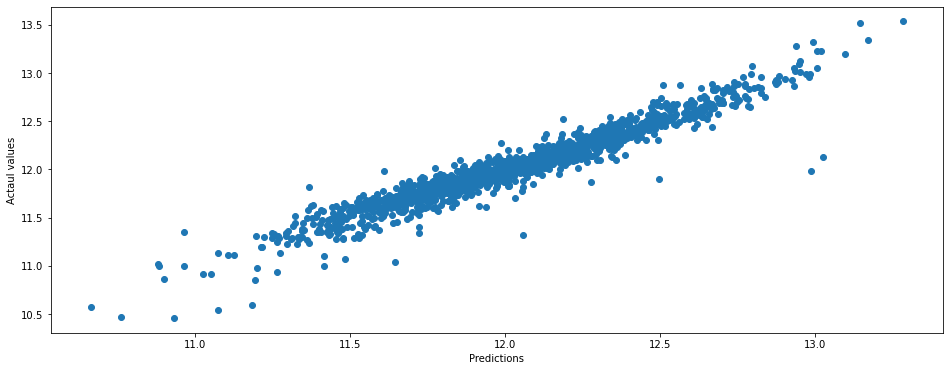

In [84]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(ridge_reg_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [85]:
fitted_ridge_reg_rmse = root_mean_square_error_pred(y, ridge_reg_pred)
print(fitted_ridge_reg_rmse)

0.10707803323392881


In [86]:
model_scores["RidgeReg"] = fitted_ridge_reg_rmse

As expected and already indicated during the examination of the $R^2$, the Ridge Regression model's predictive performance (**when using the training set!**) is lower compared to that of the linear model. However, the lower performance can be explained by lower complexity, which in turn might lead to an improved generalization of predicition results using the test data. 

### LASSO (Least Absolute Shrinkage and Selection Operator) Regression:

* The LASSO Regression is a restricted model, in which the linear regression cost function is altered by adding a penalty term equivalent to magnitudes of the coefficients.
* This type of regularization (L1) can lead to zero coefficients, i.e. some of the features are completely neglected for the evaluation of the output. So, it not only helps in reducing overfitting but it offers automatic feature selection.
* In `scikit-learn` the penalty term can be tuned via the paramter `alpha`.

As seen for the Ridge Regression model, the $\alpha$ value that leads to the best results is unknown. Hence, cross validation is used to compare several models with different $\alpha$ values with respect to their RMSE:

In [87]:
alphas_lasso = np.arange(0, 0.001, 0.0001)[1:]

In [88]:
lasso_rmse = pd.Series([root_mean_square_error_cv(Lasso(alpha = alpha, random_state = 69,
                                                        max_iter = 100000)).mean() for alpha in alphas_lasso],
                       index = alphas_lasso)

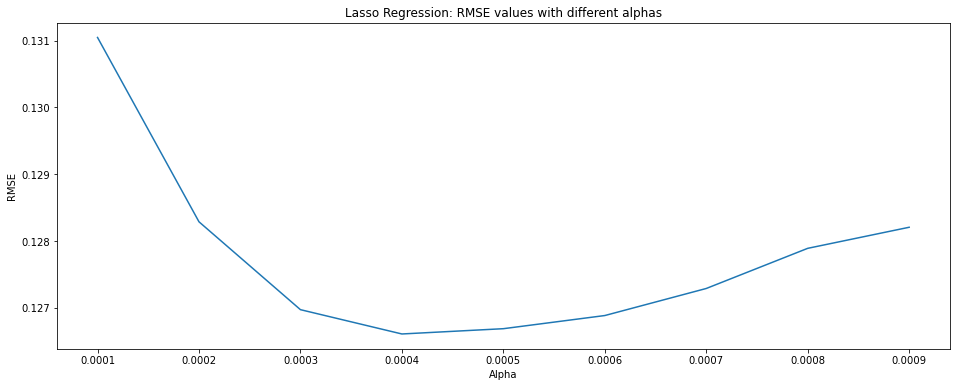

In [89]:
plt.figure(figsize=(16, 6))
lasso_rmse.plot(title = "Lasso Regression: RMSE values with different alphas")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [90]:
lasso_alpha = lasso_rmse[lasso_rmse == lasso_rmse.min()].index.values[0]

Next, a LASSO Regression model with the previously determined $\alpha$ is fitted to the training data:

In [91]:
fitted_lasso_reg = Lasso(alpha = lasso_alpha, random_state = 69, max_iter = 100000).fit(X_train, y)

In [92]:
print(round(fitted_lasso_reg.score(X_train, y), 2) * 100)

93.0


Finally, predictions using the fitted LASSO model are examined:

In [93]:
lasso_reg_pred = fitted_lasso_reg.predict(X_train)

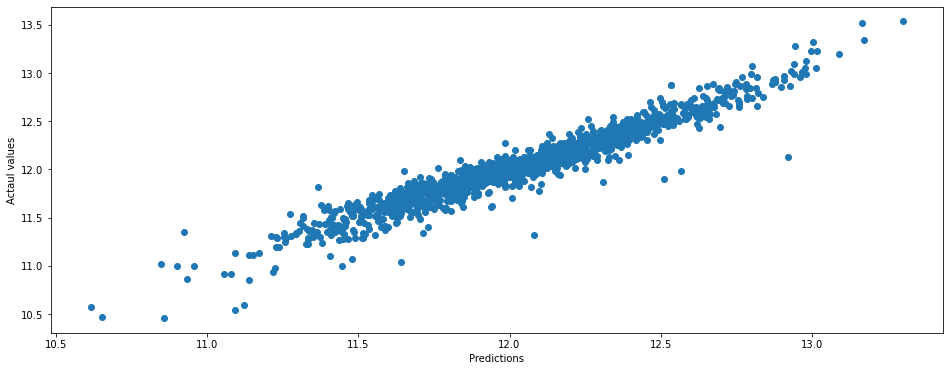

In [94]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(lasso_reg_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [95]:
fitted_lasso_reg_rmse = root_mean_square_error_pred(y, lasso_reg_pred)
print(fitted_lasso_reg_rmse)

0.10499316548956124


In [96]:
model_scores["LASSO"] = fitted_lasso_reg_rmse

The LASSO model yields a slightly lower performance compared to the Ridge Regression model. However, the differences are negligible. Hence, one might argue that shrinking features to zero is not really important to achieve better results.

### ElasticNet Regression

* The ElasticNet Regression is an additional restricted linear regression model that includes both the L1 and L2 penalties.
* It combines both the LASSO and Ridge Regression in one model: features are selected (LASSO, L1) but not shrinked to zero (Ridge, L2). The benefit is that it allows a balance of both penalties, which can result in better performance than a model with only one of the mentioned penalties.
* The ElasticNet is primarily tuned by two parameters: $\alpha$ and $\lambda$.
    * $\alpha$ determines how much weight is given to each of the L1 and L2 penalties.
    * $\lambda$ controls the weight of the overall penalty to the loss function.
* In Python (sklearn.linear_model.ElasticNet or ElasticNetCV):
    * Confusingly, $\alpha$ can be set via the “l1_ratio” argument that controls the contribution of the L1 and L2 penalties.
    * The $\lambda$ can be set via the “alpha” argument that controls the contribution of the sum of the overall penalty to the loss function.

As seen for the Ridge and LASSO Regression models, the $\alpha$ value that leads to the best results is unknown. Hence, cross validation is used to compare several models with different $\alpha$ values with respect to their RMSE:

In [97]:
alphas_elasticnet = np.arange(0, 0.002, 0.0001)[1:]

In [98]:
elasticnet_rmse = pd.Series([root_mean_square_error_cv(ElasticNet(alpha = alpha, random_state = 69,
                                                                max_iter = 100000)).mean() for alpha in alphas_elasticnet],
                            index = alphas_elasticnet)

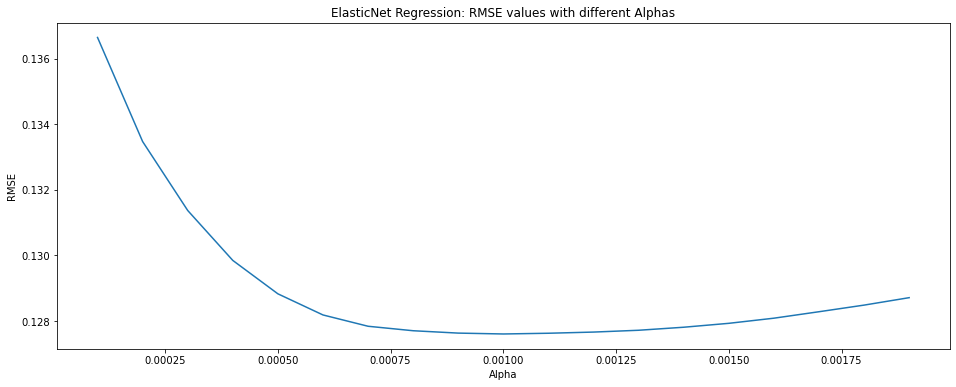

In [99]:
plt.figure(figsize=(16, 6))
elasticnet_rmse.plot(title = "ElasticNet Regression: RMSE values with different Alphas")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [100]:
elasticnet_alpha = elasticnet_rmse[elasticnet_rmse == elasticnet_rmse.min()].index.values[0]

Subsequently, an ElasticNet Regression model with the previously determined $\alpha$ and equal weights for both L1 and L2 regularization is fitted to the training data:

In [101]:
fitted_elasticnet_reg = ElasticNet(alpha = elasticnet_alpha, random_state = 69, max_iter = 100000).fit(X_train, y)

In [102]:
print(round(fitted_elasticnet_reg.score(X_train, y), 2) * 100)

92.0


Eventually, predictions are examined:

In [103]:
elasticnet_reg_pred = fitted_elasticnet_reg.predict(X_train)

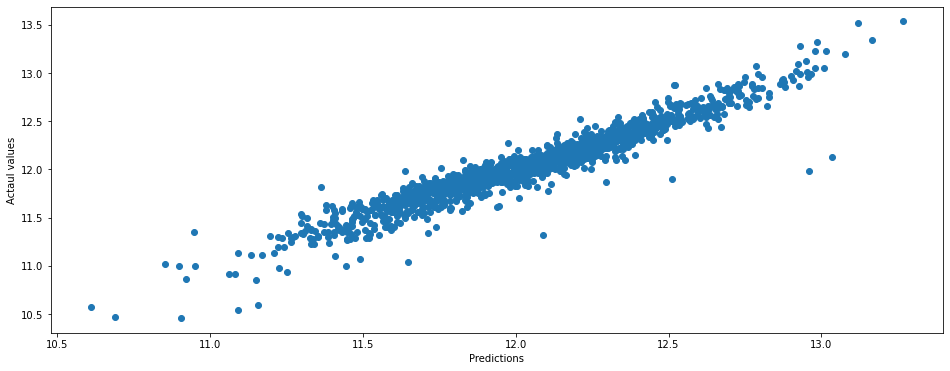

In [104]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(elasticnet_reg_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [105]:
fitted_elasticnet_reg_rmse = root_mean_square_error_pred(y, elasticnet_reg_pred)
print(fitted_elasticnet_reg_rmse)

0.10946877211083357


In [106]:
model_scores["ElasticNet"] = fitted_elasticnet_reg_rmse

As expected, the ElasticNet yields better performance than both Ridge and LASSO. Further hyperparameter tuning could improve the results since the current differences in performance are marginal.

### Support Vector Regression (SVR) 

* Support Vector Machines (SVMs) are so-called maximum-margin classifiers, which means that they attempt to maximize the distance between the closest vectors of each class and the classification line. These closest vectors are called support vectors.
* SVMs can also be used for regression. It works in a similar way, although in regression a so-called "error tube" is added. Within this tube errors are not penalized, reflecting the increased complexity of the problem (i.e. moving from a discrete problem with few classes to a regression problem with continuous features and infinite possible outcomes).


* According to `Introduction to Machine Learning with Python` the most important parameters are "C" and "gamma" (if RBF/ Gaussian kernel is used):
    * C is a regularization parameter similar to that used for restricted linear models. It limits the importance of each data point. Small values of C lead to restricted models (low influence of each data point), whereas larger values allow higher levels of complexity (strong influence).
    * Gamma controls the radius of the (Gaussian) kernel. It controls how much influence a single data point has or in other words how far the influnce of a single data point reaches. Low gamma values mean far reaching influence, larger values limit the influence to a small circle.
* Moreover, the authors argue that:
    * SVM are very sensitive to parameter tuning. Little differences in parameters may lead to substantial changes in outcome.
    * Besides parameter tuning, the scaling of data has huge impacts on SVMs and their results. Hence, it is recommended to scale the data before fitting the model.  

First: fit a SVR model with RBF kernel but without parameter tuning and data scaling:

In [107]:
print(root_mean_square_error_cv(SVR(kernel = "rbf")).mean())

0.2806139772284141


Unsurprisingly, the model did not very well. To improve results, perform min-max-scaling is performed on the training data:

In [108]:
minmaxscaler = MinMaxScaler()

In [109]:
X_train_scaled = minmaxscaler.fit_transform(X_train)

In [110]:
print(root_mean_square_error_cv(SVR(kernel = "rbf"), X_train_scaled).mean())

0.1377179853408537


Scaling the data improved the results substantially! In the following, parameters are tuned to achieve even better performance:

In [111]:
c_values_svr = np.arange(0.1, 2, 0.1)

In [112]:
svr_reg_C_rmse = pd.Series([root_mean_square_error_cv(SVR(kernel = "rbf", C = c, gamma = "scale",
                            max_iter = 100000), X_train_scaled).mean() for c in c_values_svr], index = c_values_svr)

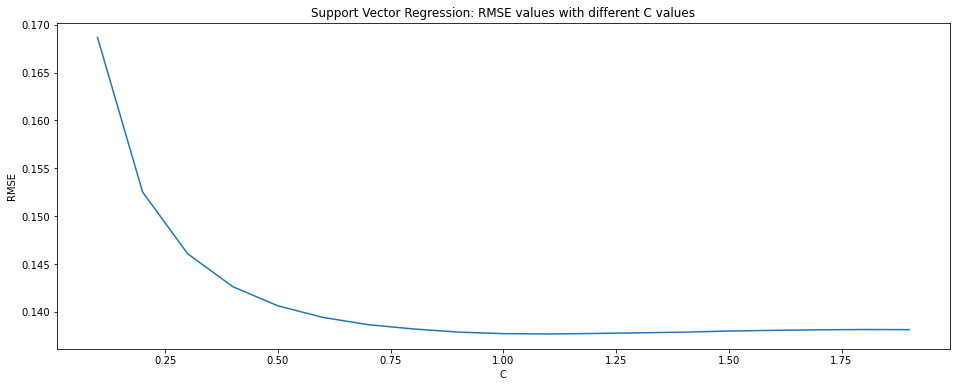

In [113]:
plt.figure(figsize=(16, 6))
svr_reg_C_rmse.plot(title = "Support Vector Regression: RMSE values with different C values")
plt.xlabel("C")
plt.ylabel("RMSE")
plt.show()

In [114]:
print(svr_reg_C_rmse[svr_reg_C_rmse == svr_reg_C_rmse.min()])

1.1    0.137683
dtype: float64


C values yielding lowest RMSE are close to default value of 1. Hence, one might argue that in our case tuning the parameter C does not add value to the analysis. Next, the parameter gamma is tuned:

In [115]:
gammas_svr = np.arange(0.001, 0.02, 0.001) 

In [116]:
svr_reg_gammas_rmse = pd.Series([root_mean_square_error_cv(SVR(kernel = "rbf", C = 1, gamma = gamma,
                            max_iter = 100000), X_train_scaled).mean() for gamma in gammas_svr], index = gammas_svr)

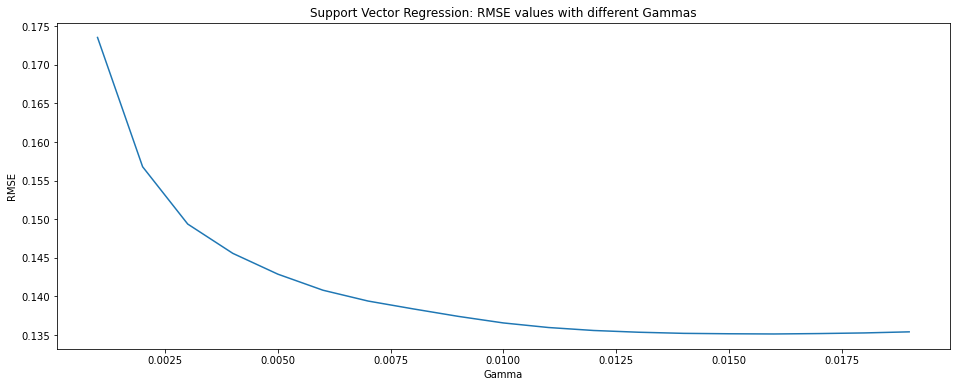

In [117]:
plt.figure(figsize=(16, 6))
svr_reg_gammas_rmse.plot(title = "Support Vector Regression: RMSE values with different Gammas")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

In [118]:
svr_reg_gammas_rmse[svr_reg_gammas_rmse == svr_reg_gammas_rmse.min()]

0.016    0.135128
dtype: float64

In [119]:
svr_gamma = svr_reg_gammas_rmse[svr_reg_gammas_rmse == svr_reg_gammas_rmse.min()].index.values[0]

Tuning gamma seems to result in a slightly lower RMSE. The determined gamma in combination with a C-value of 1 is used to fit a model: 

In [120]:
fitted_svr_reg = SVR(kernel = "rbf", C = 1, gamma = svr_gamma, max_iter = 100000).fit(X_train_scaled, y)

In [121]:
print(round(fitted_svr_reg.score(X_train_scaled, y), 2) * 100)

94.0


The $R^2$ does indicate that the model does quite well in explaining the data's variation. Moreover, overfitting seems to be no problem. Finally, predictions are examined:

In [122]:
svr_pred = fitted_svr_reg.predict(X_train_scaled)

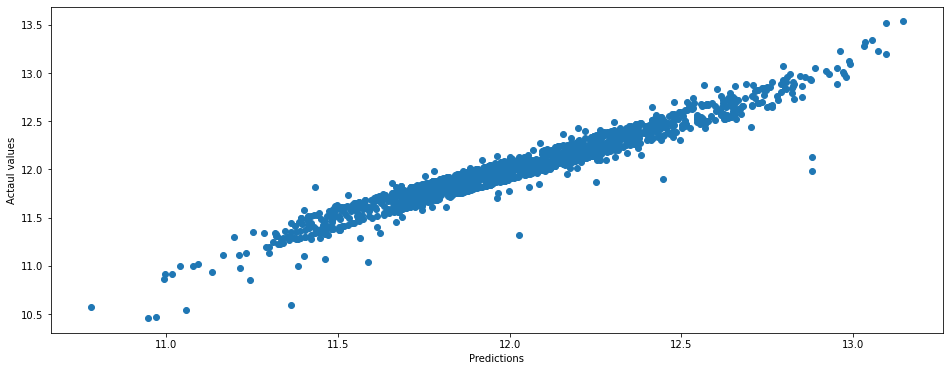

In [123]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(svr_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [124]:
fitted_svr_reg_rmse = root_mean_square_error_pred(y, svr_pred)
print(fitted_svr_reg_rmse)

0.10047390150525781


In [125]:
model_scores["SVR"] = fitted_svr_reg_rmse

The predictive performance is comparable to that of the restricted linear models.

### Decision Tree Regression

* The Decision Tree is a supervised learning algorithm for classification or regression problems.
* It has a tree-like form, which is mainly shaped by two metrics:
    * Entropy: measure of disorder or impurity in the given dataset
    * Information Gain*: measures the expected reduction in entropy
* Problems:
    * Decision Trees are sensitive to the training data. If the training data is changed the resulting decision tree can be quite different and in turn the predictions can be quite different.
    * Moreover, they carry a big risk of overfitting.
* Pruning: process to handle problems of overfitting and improve accuracy as well as performance. To prune a Decision Tree, redundant comparisons or subtrees are removed.
    * In `scikit-learn`, pre-pruning (ex-ante decision regarding the amount of comparisons/subtrees) is available and can be controlled by the parameter `max_depth`.

First: fit a Decision Tree without pruning:

In [126]:
decision_tree_full = DecisionTreeRegressor(random_state = 69)

In [127]:
print(root_mean_square_error_cv(decision_tree_full).mean())

0.2073120467694504


The $R^2$ has to be 1 (100%) for a Decision Tree model (without pruning) fitted on the training data:

In [128]:
print(round(decision_tree_full.fit(X_train, y).score(X_train, y), 2) * 100)

100.0


Next, a Decision Tree with pre-pruning using the `max_depth` parameter is fitted. As for restricted linear models, the optimal depth is unknown. Hence, several models with different depths are fitted and compared with respect to their RMSE:

In [129]:
depths_tree = [x for x in range(1, 21)]

In [130]:
decision_tree_rmse = pd.Series([root_mean_square_error_cv(DecisionTreeRegressor(max_depth = depth,
                                                random_state = 69)).mean() for depth in depths_tree], index = depths_tree)

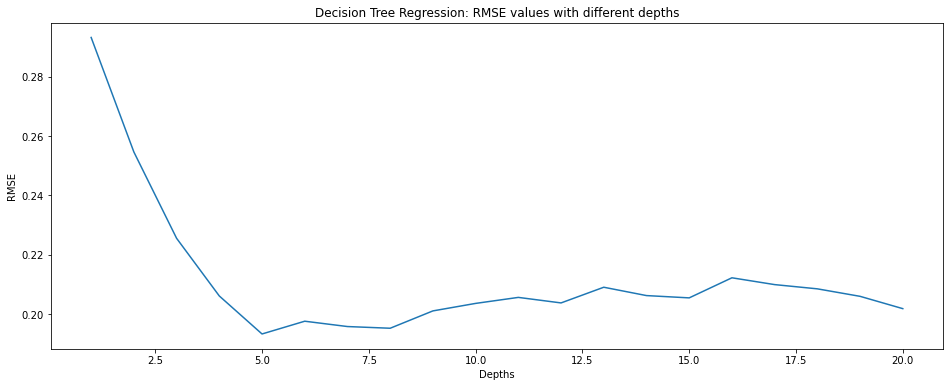

In [131]:
plt.figure(figsize=(16, 6))
decision_tree_rmse.plot(title = "Decision Tree Regression: RMSE values with different depths")
plt.xlabel("Depths")
plt.ylabel("RMSE")
plt.show()

In [132]:
decision_tree_depth = decision_tree_rmse[decision_tree_rmse == decision_tree_rmse.min()].index.values[0]

Slight improvement relative to the non-pruned decision tree. Hence, a model with the determined depth is fitted to the training data:

In [133]:
fitted_decision_tree_reg = DecisionTreeRegressor(max_depth = decision_tree_depth, random_state = 69).fit(X_train, y)

In [134]:
print(round(fitted_decision_tree_reg.score(X_train, y), 2) * 100)

84.0


Because of the pruning the $R^2$ falls to 84%. This fall in performance is however tolerable since the process of pruning yields a reduction of overfitting. Following, predictions are made:

In [135]:
decision_tree_pred = fitted_decision_tree_reg.predict(X_train)

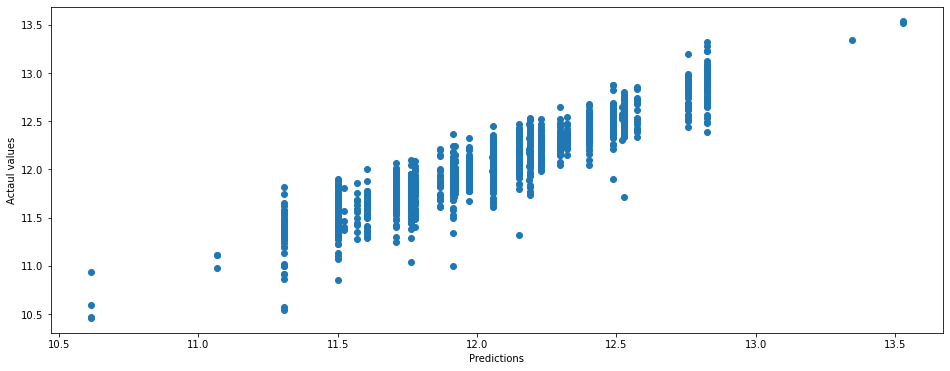

In [136]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(decision_tree_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [137]:
fitted_decision_tree_reg_rmse = root_mean_square_error_pred(y, decision_tree_pred)
print(fitted_decision_tree_reg_rmse)

0.15894508706028937


In [138]:
model_scores["DecisionTree"] = fitted_decision_tree_reg_rmse

Surprisingly, the pre-pruned decision tree model's predictive performance is inferior to that of all previously fitted models.

### Random Forest

* Like Decision Tree, Random Forests are supervised machine learning algorithms, which use ensemble learning for classification and regression.
* Random Forests construct several Decision Trees and output the class that is the mode of the classes (classification) or mean prediction (regression) of all individual trees.
* The randomness comes primarily from two sources:
    * The number of features that can be split on at each node is limited (e.g. the square root of the number of features). This ensures that the ensemble model does not rely too heavily on any individual feature, and makes fair use of all potentially predictive features.
    * Each tree draws a random sample from the original data set when generating its splits, adding more randomness that prevents overfitting.
* As seen for Decision Trees, Random Forest can be pre-pruned. In `scikit-learn` the pruning is controlled by the paramter `max_depth`.

Firstly, a Random Forest model without adjusting the depth is fitted. The parameter `n_jobs` is set to -1 to use all of the computer's core in order to facilitate the computation time:

In [139]:
random_forest_full = RandomForestRegressor(random_state = 69, n_jobs = -1).fit(X_train, y)

In [140]:
print(root_mean_square_error_cv(random_forest_full).mean())

0.14324180691896585


Already much better than the single (not pruned) Decision Tree. The next steps involve the adjustment of maximal depth:

In [141]:
depths_forest = [x for x in range(1, 26)]

In [142]:
random_forest_rmse = pd.Series([root_mean_square_error_cv(RandomForestRegressor(max_depth = depth, random_state = 69,
                                        n_jobs = -1)).mean() for depth in depths_forest], index = depths_forest) 

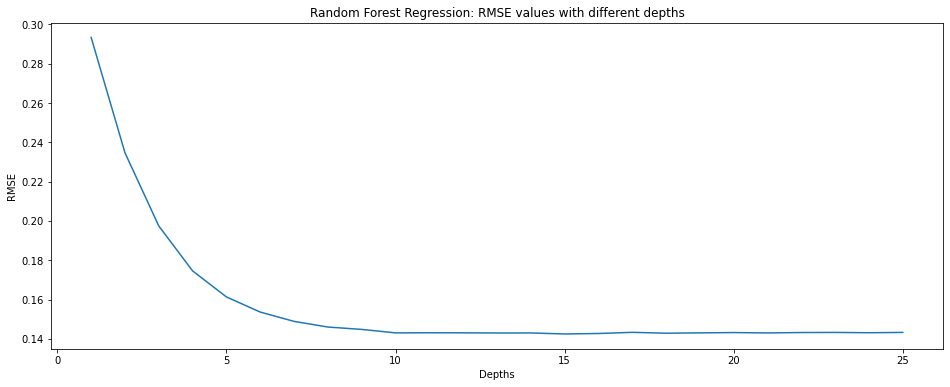

In [143]:
plt.figure(figsize=(16, 6))
random_forest_rmse.plot(title = "Random Forest Regression: RMSE values with different depths")
plt.xlabel("Depths")
plt.ylabel("RMSE")
plt.show()

In [144]:
random_forest_depth = random_forest_rmse[random_forest_rmse == random_forest_rmse.min()].index.values[0]

The depth's adjustment does not yield significantly improved results. However, the Random Forest model is fitted with the determined depth: 

In [145]:
fitted_random_forest_reg = RandomForestRegressor(max_depth = random_forest_depth,
                                                 random_state = 69, n_jobs = -1).fit(X_train, y)

In [146]:
print(round(fitted_random_forest_reg.score(X_train, y), 2) * 100)

98.0


Finally, predictions are examined:

In [147]:
random_forest_pred = fitted_random_forest_reg.predict(X_train)

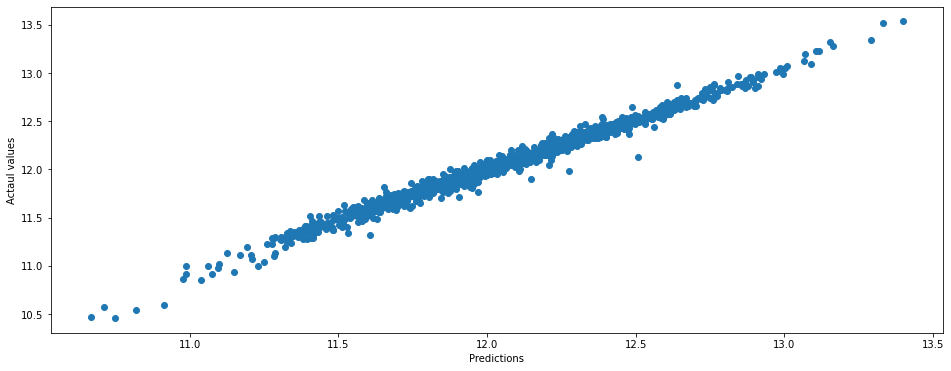

In [148]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(random_forest_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [149]:
fitted_random_forest_reg_rmse = root_mean_square_error_pred(y, random_forest_pred)
print(fitted_random_forest_reg_rmse)

0.052260362378341016


In [150]:
model_scores["RandomForest"] = fitted_random_forest_reg_rmse

The pre-pruned random forest model outperforms all previous models in predictive power.

### (Extreme) Gradient Boosting Regression Trees

* Extreme Gradient Boosting belongs to the family of boosting algorithms and uses the gradient boosting framework at its core.
* First of all: what is boosting?
    * Boosting is a sequential ensemble technique. It creates a sequence of models that attempt to correct the mistakes of the models before them in the sequence. The first model is built on training data, the second model improves the first model, the third model improves the second, and so on.
    * The process of adding models is continued until all the items in the training dataset are predicted correctly or a maximum number of models is added.
* Secondly, what is gradient boosting?*
    * As indicated by the name, gradient boosting uses the gradient descent algorithm to sequentially create improved models during training. In each step of the sequence, gradients are used to find the parameters that lead to the maximum in loss reduction.
* XGBoost:
    * Popular package for implementing the Gradient Boosting algorithm. The popularity comes, among other advantages, from its (extreme) computational speed.
    * The default base learners of XGBoost are Tree ensembles.
* XGBoost does offer a huge variety of hyperparameters. But we will focus on the following ones:
    * n_estimators: number of trees you want to build.
    * learning_rate: step size shrinkage used to prevent overfitting. Range is between 0 and 1.
    * max_depth: determines how deeply each tree is allowed to grow during any boosting round.

First, a XGB Regression without parameter tuning is fitted:

In [151]:
full_xgb_reg = xgb.XGBRegressor(random_state = 69, n_jobs = -1)

In [152]:
full_xgb_reg_rmse = root_mean_square_error_cv(full_xgb_reg).mean()

In [153]:
print(full_xgb_reg_rmse)

0.13733695844028376


The performance is as good as that of the Random Forest Regression model without tuning. In the following, it will be tried to increase the performance. According to `Introduction to Machine Learning with Python` the most important parameters are `max_depth`, `n_estimators` and `learning_rate`. All parameters are primarily used to impact over- or underfitting. A good rule of thumb is to set the value for `max_depth` not larger than 5. In the case of `n_estimators`, the advise does not include a preferable value. The authors argue that one should set a value that do not lead to a computational time beyond reason. We will set it to 100 (default value for `scikit-learn` random forests). After setting both parameters, one could search for an optimal learning rate. That process is shown in the following:

In [154]:
learning_rates = np.arange(0.01, 0.2, 0.01)

In [155]:
xgb_reg_rmse = pd.Series([root_mean_square_error_cv(xgb.XGBRegressor(max_depth = 5, n_estimators = 100,
                                                                     learning_rate = rate, random_state = 69,
                                                                     n_jobs = -1)).mean() for rate in learning_rates],
                        index = learning_rates)

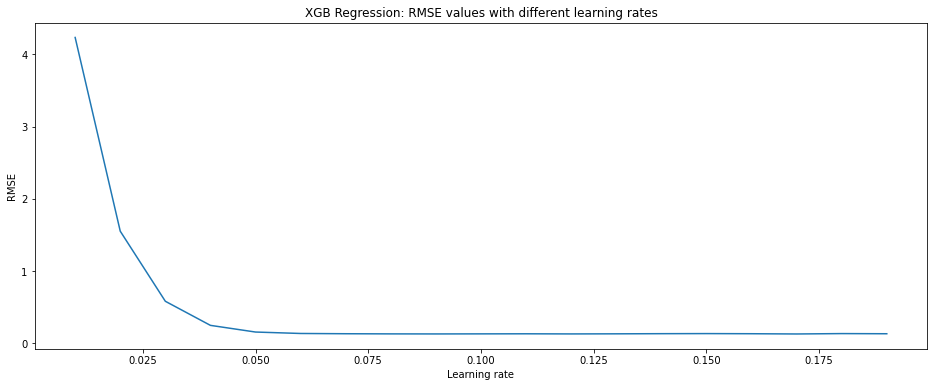

In [156]:
plt.figure(figsize=(16, 6))
xgb_reg_rmse.plot(title = "XGB Regression: RMSE values with different learning rates")
plt.xlabel("Learning rate")
plt.ylabel("RMSE")
plt.show()

In [157]:
xgb_reg_learn_rate = xgb_reg_rmse[xgb_reg_rmse == xgb_reg_rmse.min()].index.values[0]

In the following, a XGB Regression model with the determined learning rate is fitted to the training data:

In [158]:
fitted_xgb_reg = xgb.XGBRegressor(max_depth = 5, n_estimators = 100, learning_rate = xgb_reg_learn_rate,
                                  random_state = 69, n_jobs = -1).fit(X_train, y)

In [159]:
print(round(fitted_xgb_reg.score(X_train, y), 2) * 100)

99.0


Finally, predictions are examined:

In [160]:
xgb_pred = fitted_xgb_reg.predict(X_train)

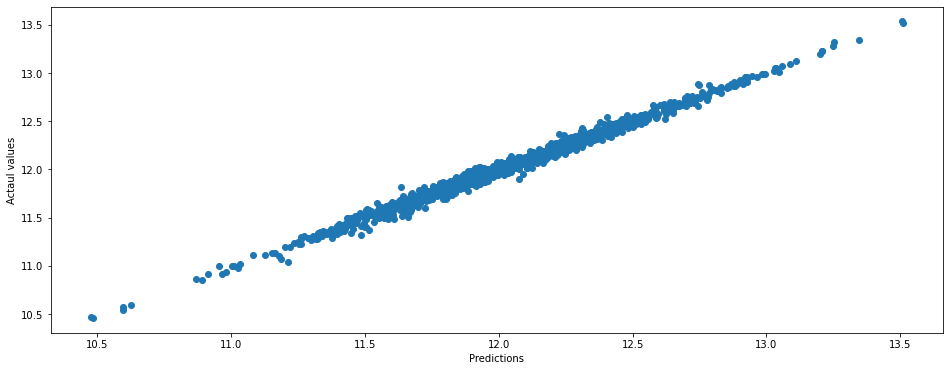

In [161]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(xgb_pred, y)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actaul values")
plt.show()

In [162]:
fitted_xgb_reg_rmse = root_mean_square_error_pred(y, xgb_pred)
print(fitted_xgb_reg_rmse)

0.03842625510646305


In [163]:
model_scores["XGB"] = fitted_xgb_reg_rmse

The XGB Regression model does perform even better than the Random Forest. However, the $R^2$ of almost 100% indicates that the model suffers from overfitting.

### Comparing the models:

In the following, the previously fitted models are compared with regards to their RMSE value on predictions using the training dataset. The model with the lowest RMSE is used to make predictions using the test data.

In [164]:
model_scores = dict(sorted(model_scores.items(), key = lambda x: x[1], reverse = True))

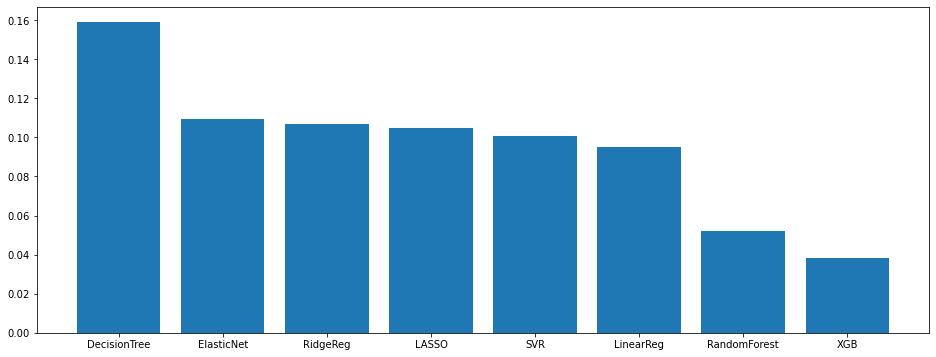

In [165]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.bar(model_scores.keys(), model_scores.values())
plt.show()

As already discussed above, the tree-based Random Forest and XGB Regression models do outperform all linear models as well as the SVR. Among the tree-based models the XGB's predictive outcome was the best. Hence, this model is used for final predictions using the test data. Finally, it should be mentioned that the simplest model, namely the (unrestricted) Linear Regression, surprisingly yielded quite good predictions. On the other hand, the Decision Tree model did not meet expectations. 

In [166]:
final_xgb_pred = fitted_xgb_reg.predict(X_test)

Note that the predictions are on log-scale since the dependent variables was log-transformed to make it more normal distributed. Before submitting is transformed back to the regular scale:

In [167]:
final_xgb_pred = np.expm1(final_xgb_pred)

In [168]:
submission_array = np.array([test_data["Id"].to_list(), final_xgb_pred.tolist()]).T

In [169]:
submission_df = pd.DataFrame(submission_array, columns = ["Id", "SalePrice"])
submission_df["Id"] = submission_df["Id"].round(decimals = 0).astype("int")

In [169]:
submission_df.to_csv("kaggle_house_prices_submission.csv", columns = ["Id", "SalePrice"], index = False)